In [1]:
num_iters = 4000
env_num = 5
spec_num = 0
use_gpu = True

In [3]:
from conformal.all_paths_conformal_pred import all_paths_conformal_pred
from conformal.bucketed_conformal_pred import bucketed_conformal_pred
from conformal.dirl_score_graphs import DIRLCumRewardScoreGraph, DIRLTimeTakenScoreGraph
from spectrl.hierarchy.construction import adj_list_from_task_graph, automaton_graph_from_spec
from spectrl.hierarchy.reachability import HierarchicalPolicy, ConstrainedEnv
from spectrl.main.spec_compiler import ev, seq, choose, alw
from spectrl.rl.ddpg.ddpg import DDPGParams
from spectrl.util.io import parse_command_line_options, save_log_info, save_object
from spectrl.util.rl import print_performance, get_rollout
from spectrl.rl.ars import HyperParams

from spectrl.examples.rooms_envs import (
    GRID_PARAMS_LIST,
    MAX_TIMESTEPS,
    START_ROOM,
    FINAL_ROOM,
)
from spectrl.envs.rooms import RoomsEnv

import os

In [ ]:
from conformal.all_paths_conformal_pred import all_paths_conformal_pred
from conformal.bucketed_conformal_pred import bucketed_conformal_pred
from conformal.calculate_coverage import calculate_coverage
from conformal.dirl_score_graphs import DIRLCumRewardScoreGraph

import dill as pickle
import json

with open("conformal_experiments_data/9rooms-counterexample-policies/path_policies.pkl", "rb") as f:
    path_policies = pickle.load(f)

with open("conformal_experiments_data/9rooms-counterexample-policies/adj_list.pkl", "rb") as f:
    adj_list = pickle.load(f)

with open("conformal_experiments_data/9rooms-counterexample-policies/terminal_vertices.pkl", "rb") as f:
    terminal_vertices = pickle.load(f)

cum_reward_score_graph = DIRLCumRewardScoreGraph(adj_list, path_policies, cum_reward_type="cum_safety_reach_reward")
n_samples = 10000
n_samples_coverage = 10000
es = [0.2, 0.1, 0.05]
total_buckets = [5, 10, 15, 20]

data_cum_reward = dict()
data_cum_reward["metadata"] = {"es": es, "total_buckets": total_buckets, "scores": "cum-reward", "env": "9-rooms", "spec": spec_num, "n_samples": n_samples}

for e in es:
    e_data = dict()
    for buckets in total_buckets:
        bucket_data = dict()
        vbs = bucketed_conformal_pred(cum_reward_score_graph, e, buckets, n_samples)
        min_path, min_path_scores = all_paths_conformal_pred(cum_reward_score_graph, e, n_samples)
        vb = vbs.buckets[(terminal_vertices[0], buckets)]

        bucket_data["bucketed"] = {"path": vb.path, 
                                   "path_buckets": vb.path_buckets, 
                                   "path_score_quantiles": vb.path_score_quantiles, 
                                   "max_path_score_quantile": max(vb.path_score_quantiles)}
        bucket_data["all-paths"] = {"path": min_path, "min_path_scores": min_path_scores, "max_min_path_scores": max(min_path_scores)}

        bucket_data["bucketed-coverage"] = calculate_coverage(
            cum_reward_score_graph, vb.path, vb.path_score_quantiles, n_samples_coverage
        )
        bucket_data["all-paths-coverage"] = calculate_coverage(
            cum_reward_score_graph, 
            min_path, 
            [max(min_path_scores) for _ in range(len(min_path)-1)], 
            n_samples_coverage,
        )
        e_data[buckets] = bucket_data
    data_cum_reward[str(e)] = e_data

# Convert the Python object to a JSON string
json_data = json.dumps(data_cum_reward, indent=2)

# Store the JSON string in a file
with open("conformal_experiments_data/9rooms-counterexample-cum-reward.json", "w") as json_file:
    json_file.write(json_data)

with open("conformal_experiments_data/9rooms-counterexample-policies/cum-rew-score-graph.pkl", "wb") as f:
    pickle.dump(cum_reward_score_graph, f)


Drawing samples for [0] -> 1


  0%|          | 0/10000 [00:00<?, ?it/s]

100%|██████████| 10000/10000 [01:28<00:00, 113.61it/s]


Drawing samples for [0] -> 2


100%|██████████| 10000/10000 [01:28<00:00, 113.36it/s]


Drawing samples for [0, 1] -> 3


100%|██████████| 10000/10000 [01:27<00:00, 113.76it/s]


Drawing samples for [0, 2] -> 3


100%|██████████| 10000/10000 [01:27<00:00, 114.22it/s]


Drawing samples for [0] -> 2


100%|██████████| 10000/10000 [01:28<00:00, 113.50it/s]


Drawing samples for [0, 2] -> 3


100%|██████████| 10000/10000 [01:27<00:00, 114.19it/s]


In [6]:
trajectories_scores1 = cum_reward_score_graph.sample_full_path_cached([0, 1, 3], n_samples)
trajectories_scores2 = cum_reward_score_graph.sample_full_path_cached([0, 2, 3], n_samples)

# trajectories_scores1 = cum_reward_score_graph.sample_full_path_cached([0, 1], n_samples)
# trajectories_scores2 = cum_reward_score_graph.sample_full_path_cached([0, 1], n_samples)

successful_trajs1, successful_trajs2 = 0, 0

for i in range(n_samples):
    if all(trajectories_scores1[i][j] <= 0 for j in range(2)):
        successful_trajs1 += 1
    if all(trajectories_scores2[i][j] <= 0 for j in range(2)):
        successful_trajs2 += 1

print("path 1 success prob " + str(successful_trajs1/n_samples))
print("path 2 success prob " + str(successful_trajs2/n_samples))

Drawing samples for [0] -> 1


100%|██████████| 10000/10000 [01:28<00:00, 113.21it/s]


Drawing samples for [0, 1] -> 3


100%|██████████| 10000/10000 [01:28<00:00, 113.39it/s]

path 1 success prob 1.0
path 2 success prob 1.0


In [7]:
with open("conformal_experiments_data/9rooms-counterexample-policies/cum-rew-score-graph.pkl", "wb") as f:
    pickle.dump(cum_reward_score_graph, f)

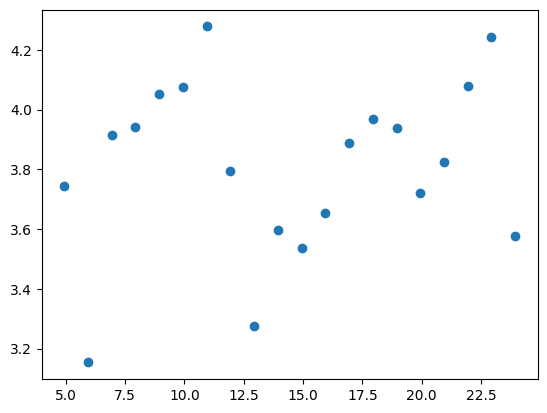

In [14]:
import matplotlib.pyplot as plt
import numpy as np

pp = cum_reward_score_graph.path_policies.get_vertex_path_policy([0])
sarss = get_rollout(
    pp.reach_envs[1],
    pp.policies[1],
    False,
    init_state=None
)
states = [state for state, _, _, _ in sarss] + [sarss[-1][-1]]
x_coords = [state[0] for state in states]
y_coords = [state[1] for state in states]

# Plot the points
plt.scatter(y_coords, x_coords)

[8.951920929984633, 7.954876804469033, 6.961256615436351, 5.970793757694742, 4.973419671880259, 3.974164561890137, 2.9745106095520564, 1.974657679830174, 0.9746586994152873, -0.025341300032347525, 0.4920079666983836, 1.4920079666983836, 2.4920079666983836, 3.4920079666983836, 4.492007966698384, 5.492007966698384, 6.492007966698384, 7.492007966698384, 8.492007966698383, 9.492007966698383, 10.492007966698383, 11.492007966698383, 12.492007966698383, 13.492007966698383, 13.492007966698383, 13.492007966698383, 13.492007966698383, 13.492007966698383, 13.492007966698383, 13.492007966698383, 13.492007966698383, 13.492007966698383, 13.492007966698383, 13.492007966698383, 13.492007966698383, 13.492007966698383, 13.492007966698383, 13.492007966698383, 13.492007966698383, 13.492007966698383, 13.492007966698383, 13.492007966698383]


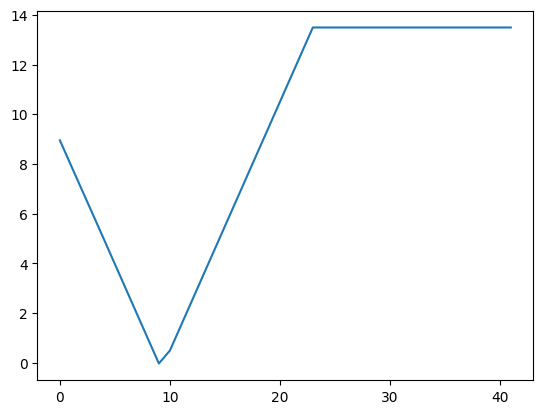

In [ ]:
reach_env = pp.reach_envs[1]
safety_rewards = []
for s in states:
    safety_rewards.append(reach_env.constraints[0](s, None))

print(safety_rewards)
plt.plot(safety_rewards)